# Exploration : No Exam Modules
Our discussion and data exploration led to the discovery that 350 modules have no exam at all in their assessment. This is over 60% of the entire college of Enigineering and Architecture, and are likely to be at a much greater risk of ChatGPT then others. This notebook is for finding out which groups exist within this subset of data, and assessing their threat level. 

## Import Necessary Libraries and Functions
First we will need some imports.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import re
import pathlib as Path
import html5lib
import json
import matplotlib.ticker as mtick
import plotly.express as px
import sklearn 
import warnings
warnings.filterwarnings("ignore")

We will need a file finder for this, so we will copy that over.

In [2]:
#This finds files that were saved by the Module Scraper Code
def file_finder(school=None, level=None, givenList=None, filename=None, module=None):
    #Set the path to the overall directory with our input files
    dir_raw=Path.Path("ModuleInformation")
    
    #This locates the subdirectory where files by school, level or list can be found
    subdirectory=""
    #Set the subdirectory 
    if level != None:
        subdirectory+= "Level=%d" %(level)
    if school != None:
        subdirectory+= "_School="+school.replace(" ", "-")
    if filename != None:
        subdirectory = filename
    if module != None:
        subdirectory = ("IndividualModules/%s" %module)
        
    #If a subdirectory has indeed been set, change the path to reflect this
    if len(subdirectory) > 0:
        dir_raw =dir_raw / subdirectory
        

    #Read the files for the assessment and descriptors in, closing the file immediately after
    with open(dir_raw / "assessments.json", 'r') as infile:
        print("Reading from %s" % dir_raw)
        if module != None:
            assessments=pd.read_json(infile, orient="columns")
        else:
            assessments=pd.read_json(infile)
    with open(dir_raw / "descriptors.json", 'r') as infile:
        print("Reading from %s" % dir_raw)
        if module != None:
            descriptors=pd.read_json(infile, typ="series")
        else:
            descriptors=pd.read_json(infile)
    
    assessments["Level"]=assessments["Level"].apply(lambda x: pd.to_numeric(x.split('(')[0], errors='ignore'))
    #This is the dataset cleaning, so that they are ready for presentation
    assessments["% of Final Grade"]=pd.to_numeric(assessments["% of Final Grade"], errors='coerce')
    assessments=assessments.replace("Multiple Choice Questionnaire (Short)", "Multiple Choice Questionnaire")
    assessments["Assessment Type"]=assessments["Assessment Type"].astype("category")
    #assessments["Stage"]=assessments["Stage"].replace("M", 4)
    assessments["Student Credits"]=((assessments["Scaled % of Final Grade"]/100)*5)*assessments["Enrolled Students 22/23"]
    assessments["Assessment Credits"]=((assessments["Scaled % of Final Grade"]/100)*5)
    #Return the desired assessment and description information
    return assessments, descriptors

Print out the assessments to test.

In [3]:
#Test the file finder function 
assessments, descriptors = file_finder()

assessments

Reading from ModuleInformation
Reading from ModuleInformation


,Description,Timing,Open Book Exam,Component Scale,Must Pass Component,% of Final Grade,Assessment Type,Module Code,Scaled % of Final Grade,Work Type,Level,Credits,School,Module Coordinator,Semester,Enrolled Students 22/23,Stage,Student Credits,Assessment Credits
0,Fieldwork: Fieldwork on campus related to camp...,Throughout the Trimester,None,Graded,No,30,Fieldwork,DSCY10060,30,In person,1,5.0,Electrical & Electronic Eng,Professor Andrew Keane,Spring,37,NaN,55.5,1.50
1,Presentation: In class presentation of group p...,Week 12,None,Graded,No,30,Presentation,DSCY10060,30,In person,1,5.0,Electrical & Electronic Eng,Professor Andrew Keane,Spring,37,NaN,55.5,1.50
2,Multiple Choice Questionnaire: Online Multiple...,Throughout the Trimester,None,Standard conversion grade scale 40%,No,40,Multiple Choice Questionnaire,DSCY10060,40,Blended,1,5.0,Electrical & Electronic Eng,Professor Andrew Keane,Spring,37,NaN,74.0,2.00
3,Examination: 2 HOUR Examination,2 hour End of Trimester Exam,No,Alternative linear conversion grade scale 40%,No,65,Examination,EEEN10010,65,In person,1,5.0,Electrical & Electronic Eng,Assoc Professor Simon Kelly,Autumn,298,NaN,968.5,3.25
4,"Lab Report: Two in-person labs will be run , w...",Varies over the Trimester,None,Alternative linear conversion grade scale 40%,No,10,Lab Report,EEEN10010,10,Blended,1,5.0,Electrical & Electronic Eng,Assoc Professor Simon Kelly,Autumn,298,NaN,149.0,0.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1270,Assignment: Final report and presentation,Throughout the Trimester,None,Pass/Fail Grade Scale,Yes,70,Assignment,MEEN50080,280,At home,5,20.0,Mechanical & Materials Eng,Dr David McKeown,Autumn&Spring&Summer(separate),0,NaN,0.0,14.00
1271,Assignment: Industrial Partner Assessment form,Throughout the Trimester,None,Pass/Fail Grade Scale,No,10,Assignment,MEEN50080,40,At home,5,20.0,Mechanical & Materials Eng,Dr David McKeown,Autumn&Spring&Summer(separate),0,NaN,0.0,2.00
1272,Assignment: Development of work plan,Throughout the Trimester,None,Pass/Fail Grade Scale,Yes,20,Assignment,MEEN50090,120,At home,5,30.0,Mechanical & Materials Eng,Dr David McKeown,Autumn&Spring&Summer(separate),0,NaN,0.0,6.00
1273,Assignment: Industrial Partner Assessment form,Throughout the Trimester,None,Pass/Fail Grade Scale,No,10,Assignment,MEEN50090,60,At home,5,30.0,Mechanical & Materials Eng,Dr David McKeown,Autumn&Spring&Summer(separate),0,NaN,0.0,3.00


This is an important dict that shows where module assessment types are performed.

In [4]:
work_type={"Assignment" :"At home", \
                "Attendance": "In person", \
                "Class Test" : "In person", \
                "Continuous Assessment": "At home", \
               "Essay": "At home", \
                "Examination": "In person", \
                "Fieldwork": "In person", \
                "Group Project": "Blended", \
                "Journal": "Blended",\
               "Lab Report": "Blended", \
                "Multiple Choice Questionnaire": "Blended", \
                "Oral Examination": "In person", \
               "Portfolio" : "Blended",  \
                "Practical Examination": "In person", \
                "Presentation" : "In person", \
                "Project": "At home", \
               "Seminar": "In person", \
               "Studio Examination" : "In person",\
               "Assessments worth <2%": "Unknown"}

## Create Module Analysis Dataframe

We will need to pivot the assessments table and set up the module analysis dataframe. Next we will save this, as a very important dataframe.

In [5]:
module_analysis=assessments.pivot_table("% of Final Grade", \
                               ["School", "Level", "Module Code", "Enrolled Students 22/23", "Credits"], \
                               "Assessment Type", observed=True, fill_value=0)
module_analysis.reset_index( inplace=True)
#Reset the index and make a new index of all the columns that should make a row unique
#module_analysis.set_index("Module Code", inplace=True)

module_analysis["Student Credits"]=module_analysis["Enrolled Students 22/23"]*module_analysis["Credits"]

work_type={"Assignment" :"At home", \
                "Attendance": "In person", \
                "Class Test" : "In person", \
                "Continuous Assessment": "At home", \
               "Essay": "At home", \
                "Examination": "In person", \
                "Fieldwork": "In person", \
                "Group Project": "Blended", \
                "Journal": "Blended",\
               "Lab Report": "Blended", \
                "Multiple Choice Questionnaire": "Blended", \
                "Oral Examination": "In person", \
               "Portfolio" : "Blended",  \
                "Practical Examination": "In person", \
                "Presentation" : "In person", \
                "Project": "At home", \
               "Seminar": "In person", \
               "Studio Examination" : "In person",\
               "Assessments worth <2%": "Unknown"}

module_analysis["In Person Percentage"]=module_analysis["Attendance"]+module_analysis["Class Test"]+\
module_analysis["Examination"]+module_analysis["Fieldwork"]+module_analysis["Oral Examination"]\
+module_analysis["Practical Examination"]+module_analysis["Presentation"]+module_analysis["Seminar"]+\
module_analysis["Studio Examination"]

module_analysis["At Home Percentage"]=module_analysis["Assignment"]+module_analysis["Continuous Assessment"]+\
module_analysis["Essay"]+module_analysis["Project"]

module_analysis["Blended Percentage"]=module_analysis["Group Project"]+module_analysis["Journal"]+\
module_analysis["Lab Report"]+module_analysis["Multiple Choice Questionnaire"]+module_analysis["Portfolio"]
module_analysis

Assessment Type,School,Level,Module Code,Enrolled Students 22/23,Credits,Assignment,Attendance,Class Test,Continuous Assessment,Essay,...,Portfolio,Practical Examination,Presentation,Project,Seminar,Studio Examination,Student Credits,In Person Percentage,At Home Percentage,Blended Percentage
0,"Architecture, Plan & Env Pol",1,ARCT10010,72,15.0,0.000000,0,0.0,0.0,0.0,...,100,0,0.0,0.0,0,0.0,1080.0,0.0,0.000000,100.0
1,"Architecture, Plan & Env Pol",1,ARCT10020,61,15.0,0.000000,0,0.0,0.0,0.0,...,100,0,0.0,0.0,0,0.0,915.0,0.0,0.000000,100.0
2,"Architecture, Plan & Env Pol",1,ARCT10030,78,5.0,0.000000,0,0.0,0.0,0.0,...,0,0,0.0,50.0,0,0.0,390.0,0.0,50.000000,0.0
3,"Architecture, Plan & Env Pol",1,ARCT10040,61,5.0,0.000000,0,0.0,0.0,10.0,...,50,0,0.0,0.0,0,0.0,305.0,40.0,10.000000,50.0
4,"Architecture, Plan & Env Pol",1,ARCT10070,80,5.0,10.000000,0,0.0,0.0,30.0,...,0,0,0.0,0.0,0,0.0,400.0,40.0,40.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
508,Mechanical & Materials Eng,5,MEEN50020,0,5.0,0.000000,0,0.0,0.0,0.0,...,0,0,0.0,100.0,0,0.0,0.0,0.0,100.000000,0.0
509,Mechanical & Materials Eng,5,MEEN50060,0,15.0,0.000000,0,0.0,70.0,0.0,...,0,0,30.0,0.0,0,0.0,0.0,30.0,70.000000,0.0
510,Mechanical & Materials Eng,5,MEEN50070,0,10.0,33.333333,0,0.0,0.0,0.0,...,0,0,0.0,0.0,0,0.0,0.0,0.0,33.333333,0.0
511,Mechanical & Materials Eng,5,MEEN50080,0,20.0,33.333333,0,0.0,0.0,0.0,...,0,0,0.0,0.0,0,0.0,0.0,0.0,33.333333,0.0


Now we will move on to limit the module analysis to just those modules that have no examination component. Here we will also filter out the modules that are in their own categories - the internship and theses, as these are less susceptible to ChatGPT cheating than more normal modules.

In [6]:
#Remove Internships and Theses
#Set the path
Datasets=Path.Path("Datasets")
#Get the internship modules
internship_file= Datasets / "UCD_EngArch_InternshipModules.xlsx"
internships=pd.read_excel(internship_file)
#Get the thesis modules
thesis_file= Datasets / "UCD_EngArch_FYPModules.xlsx"
theses=pd.read_excel(thesis_file)

#Filter out internships and theses
module_analysis=module_analysis[~module_analysis["Module Code"].isin(internships["Code"])]
module_analysis=module_analysis[~module_analysis["Module Code"].isin(theses["Code"])]

#Reset the index and make a new index of all the columns that should make a row unique
module_analysis.set_index("Module Code", inplace=True)

#Filter out modules that have any exam component, and modules that had no students last year
no_exam=module_analysis[module_analysis["Examination"]==0]
no_exam=no_exam[no_exam["Studio Examination"]==0]
no_exam=no_exam[no_exam["Practical Examination"]==0]
no_exam=no_exam[no_exam["Oral Examination"]==0]
no_exam=no_exam[no_exam["Enrolled Students 22/23"] >0]

no_exam

Assessment Type,School,Level,Enrolled Students 22/23,Credits,Assignment,Attendance,Class Test,Continuous Assessment,Essay,Examination,...,Portfolio,Practical Examination,Presentation,Project,Seminar,Studio Examination,Student Credits,In Person Percentage,At Home Percentage,Blended Percentage
Module Code,,,,,,,,,,,,,,,,,,,,,
ARCT10010,"Architecture, Plan & Env Pol",1,72,15.0,0.0,0,0.0,0.0,0.0,0,...,100,0,0.0,0.0,0,0.0,1080.0,0.0,0.0,100.0
ARCT10020,"Architecture, Plan & Env Pol",1,61,15.0,0.0,0,0.0,0.0,0.0,0,...,100,0,0.0,0.0,0,0.0,915.0,0.0,0.0,100.0
ARCT10030,"Architecture, Plan & Env Pol",1,78,5.0,0.0,0,0.0,0.0,0.0,0,...,0,0,0.0,50.0,0,0.0,390.0,0.0,50.0,0.0
ARCT10120,"Architecture, Plan & Env Pol",1,64,5.0,25.0,0,0.0,0.0,0.0,0,...,0,0,0.0,0.0,0,0.0,320.0,0.0,25.0,50.0
ENVP10010,"Architecture, Plan & Env Pol",1,171,5.0,0.0,0,0.0,30.0,0.0,0,...,0,0,0.0,0.0,0,0.0,855.0,0.0,30.0,45.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MEEN41120,Mechanical & Materials Eng,4,23,7.5,30.0,0,20.0,0.0,0.0,0,...,0,0,0.0,0.0,0,0.0,172.5,20.0,30.0,30.0
MEEN41130,Mechanical & Materials Eng,4,12,2.5,0.0,0,0.0,0.0,0.0,0,...,0,0,100.0,0.0,0,0.0,30.0,100.0,0.0,0.0
MEEN41160,Mechanical & Materials Eng,4,14,5.0,7.0,0,0.0,13.0,0.0,0,...,0,0,6.0,38.0,0,0.0,70.0,6.0,58.0,30.0


In [7]:
no_exam["School"].unique()

array(['Architecture, Plan & Env Pol', 'Biosystems & Food Engineering',
       'Chem & Bioprocess Engineering', 'Civil Engineering',
       'Electrical & Electronic Eng', 'Mechanical & Materials Eng'],
      dtype=object)

In [8]:
no_exam["Level"].unique()

array([1, 2, 3, 4], dtype=int64)

In [9]:
thesis=no_exam[no_exam["Credits"]>=20]

thesis

Assessment Type,School,Level,Enrolled Students 22/23,Credits,Assignment,Attendance,Class Test,Continuous Assessment,Essay,Examination,...,Portfolio,Practical Examination,Presentation,Project,Seminar,Studio Examination,Student Credits,In Person Percentage,At Home Percentage,Blended Percentage
Module Code,,,,,,,,,,,,,,,,,,,,,
BSEN40800,Biosystems & Food Engineering,4,17,30.0,0.0,0,0.0,0.0,0.0,0,...,0,0,0.0,50.0,0,0.0,510.0,0.0,50.0,0.0


## Data Visualisations

What does a "no exam" module look like in terms of assessment. Let's look at the whole college...

In [57]:
#Builds a graph to indicate the susceptibility of a module set's assessments to Chat GPT
def workType_builder(assessments, school=None, level=None):
    #Data Cleaning and Manipulation Part
    #########################################################################################

    new_assessments=assessments
    
    if school !=None:
        new_assessments=new_assessments[new_assessments["School"]==school]
    if level != None:
        new_assessments=new_assessments[new_assessments["Level"]==level]
        
    num_unique=len(assessments)
    
    assessments_list=["Assignment", "Attendance", "Class Test", "Continuous Assessment", "Essay", \
                "Examination", "Fieldwork", "Group Project", "Journal", "Lab Report", "Multiple Choice Questionnaire", \
                "Oral Examination", "Portfolio", "Practical Examination", "Presentation", "Project", \
               "Seminar", "Studio Examination"]
    type_percentages=["In Person Percentage", "At Home Percentage", "Blended Percentage"]
    
    average={}
    total={}
    Real_assessments_list=[]
    for column in new_assessments.columns:
        if column in assessments_list or column in type_percentages:
            mean = new_assessments[column].mean()
            total= new_assessments[column].sum()
            if mean > 0.0 :
                if column not in type_percentages:
                    Real_assessments_list.append(column)
                average[column]= mean
            
            
    
    average_assess=pd.Series(average)
    average_assess=average_assess.sort_values(ascending=False)

    #Graph building part
    #############################################################################################################
    #Set the font
    plt.rcParams["font.family"] = "sans"
    
    #Make the figure
    fig, (ax, bx)=plt.subplots(ncols=2, figsize=(16, 9))

    #Make a pie chart on the desired axes
    fig, ax=workType_pie(average_assess[type_percentages], fig, ax, num_unique)

        
    #Make the horizontal bar chart on the desired axes
    fig, bx=workType_barh(average_assess[Real_assessments_list].sort_values(ascending=False), fig, bx)
    
    #Here we want to set the overall title of the charts - to indicate what module subset they are describing
    what="Modules Without Exams in the College of Engineering and Architecture"
    if school != None:
        what="No Exam Modules in the "
        what+="School of "
        what+=school
    if level != None:
        what+= " At Level %d" %level
        
    #Set the overall title for the two graphs
    fig.suptitle("Assessment Breakdown in the %s" %what, fontsize=24)
    fig.tight_layout()
    
    #Describe what the figure is
    what=what.replace(" ", "-")
    
    #Set the path to save the graphs
    dir_output=Path.Path("Graphs")
    
    #Set the filename for th figure
    dir_output=dir_output / "ModulesNoExams"
    dir_output.mkdir(parents=True, exist_ok=True)
    
    filename= dir_output / ("%s.pdf" %what)
    plt.savefig(filename, dpi="figure")

In [58]:
def workType_pie(assessment_sus, fig, ax, num_unique=None):
        #These are for selecting colours and hatching for each pie segment
    colour_dict={"At Home Percentage": "#1f78b4", "Blended Percentage": "#a6cee3", "In Person Percentage":"#b2df8a"}
    hatching_dict={"At Home": None, "Blended": None, "In person":None}
    colours=[]
    hatching=[]
    #Get the colours and hatching for each pie segment
    for segment in assessment_sus.index:
        colours.append(colour_dict[segment])
        #hatching.append(hatching_dict[segment])

    #Make the susceptibility pie chart
    ax.pie(assessment_sus[["At Home Percentage", "Blended Percentage", "In Person Percentage"]],\
           wedgeprops = { 'linewidth' : 1.5, 'edgecolor' : 'white', "alpha" : 0.9}, \
           autopct="%1.1f%%", labels=assessment_sus.index,\
           colors=colours, textprops={'fontsize':18})

    #Set the title of the pie chart for ease of understanding
    ax.set_title("Proportions of Different Assessment Kinds", fontsize=20)
    
    if num_unique!=None:
        ax.set_xlabel("\n\nNumber of Modules in this Breakdown: %d" %(num_unique), fontsize=20)
    
    return fig, ax

In [59]:
def workType_barh(sorted_totals, fig, bx):
    #These are for selecting colours and hatching for each bar in the bar chart
    colour_dict={"At home": "#1f78b4", "Blended": "#a6cee3", "In person":"#b2df8a"}
    hatching_dict={"At home": None, "Blended": None, "In person":None}
    colours=[]
    hatching=[]
    
    #Get the colours and hatching type based on susceptibilty
    for sus in sorted_totals.index:
        #if sus in assessment_list:
        colours.append(colour_dict[work_type[sus]])
        hatching.append(hatching_dict[work_type[sus]])
        
    #Make the assessment type breakdown bar chart, with colour and hatching indicating the susceptibility
    bx.barh(sorted_totals.index, sorted_totals, edgecolor="white", hatch = hatching ,\
           color=colours, alpha=0.9)
    
    #colors = {'fruit':'red', 'veggie':'green'}         
    #Set the options for the axes
    bx.tick_params(axis='y', labelsize=16)
    bx.tick_params(axis='x', labelsize=14)
    
    fmt = '%d%%' # Format you want the ticks, e.g. '40%'
    xticks = mtick.FormatStrFormatter(fmt)
    bx.xaxis.set_major_formatter(xticks)
    #ax.legend(fontsize=20)
    bx.set_xlabel("Percentage of Assessment",fontsize=18)
    #Set the title for the bar chart for ease of understanding
    bx.set_title("Assessment Type Breakdown", fontsize=20)
    
    #Do the legend
    labels = list(colour_dict.keys())
    handles = [plt.Rectangle((0,0),1,1, color=colour_dict[label]) for label in labels]
    bx.legend(handles, labels,fontsize=20)
    
    return fig, bx

For each school, let's examine the average breakdown of assessment for modules that do not feature an examination.

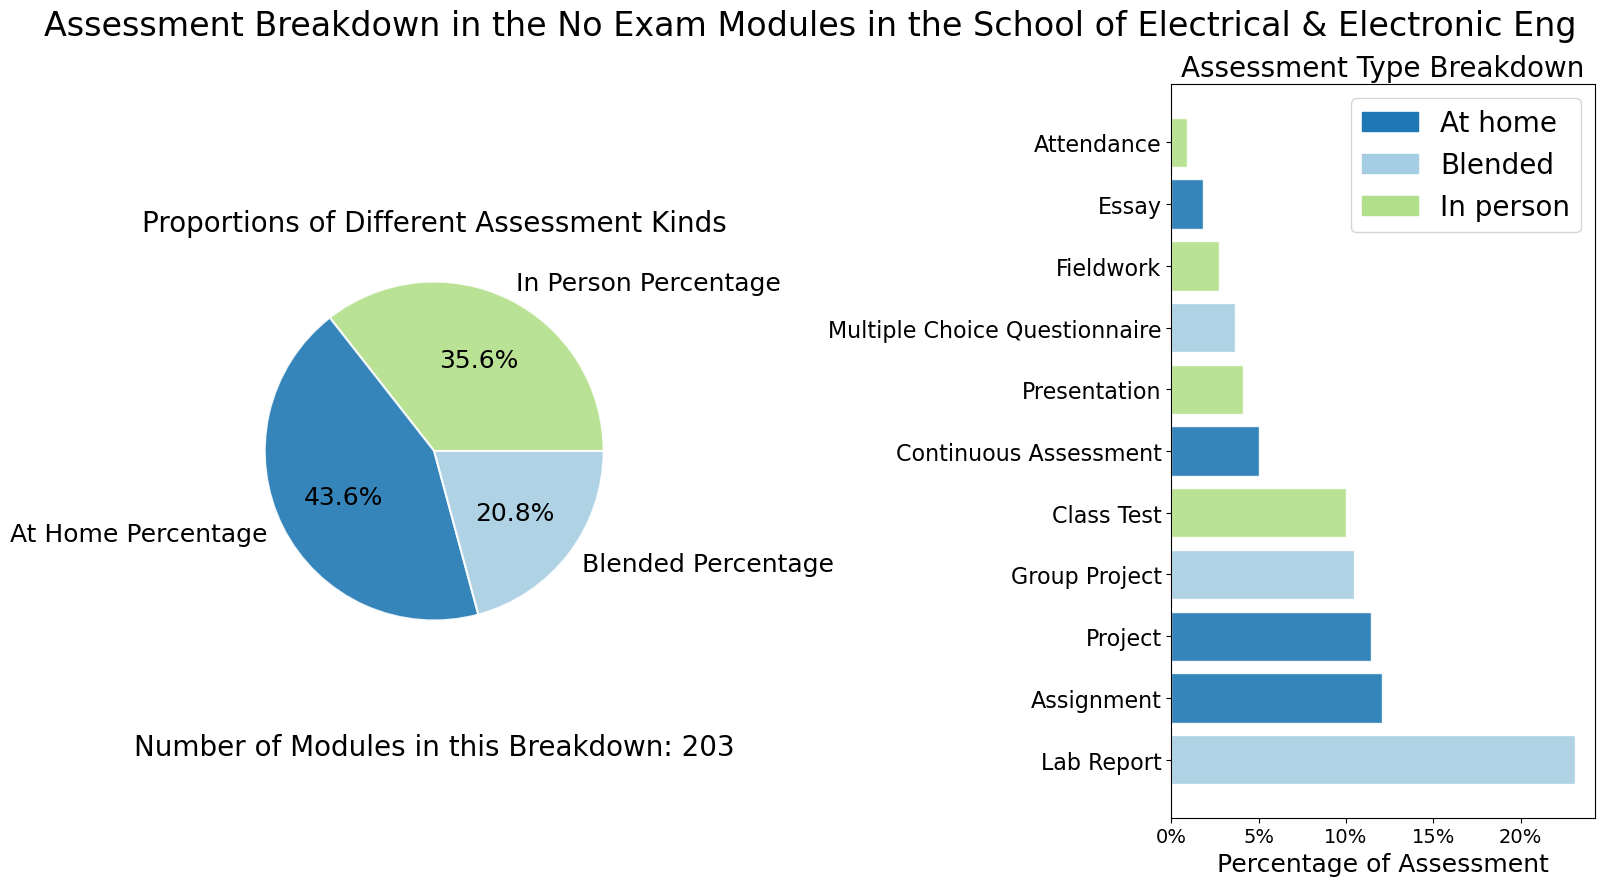

In [60]:
workType_builder(no_exam, school="Electrical & Electronic Eng")

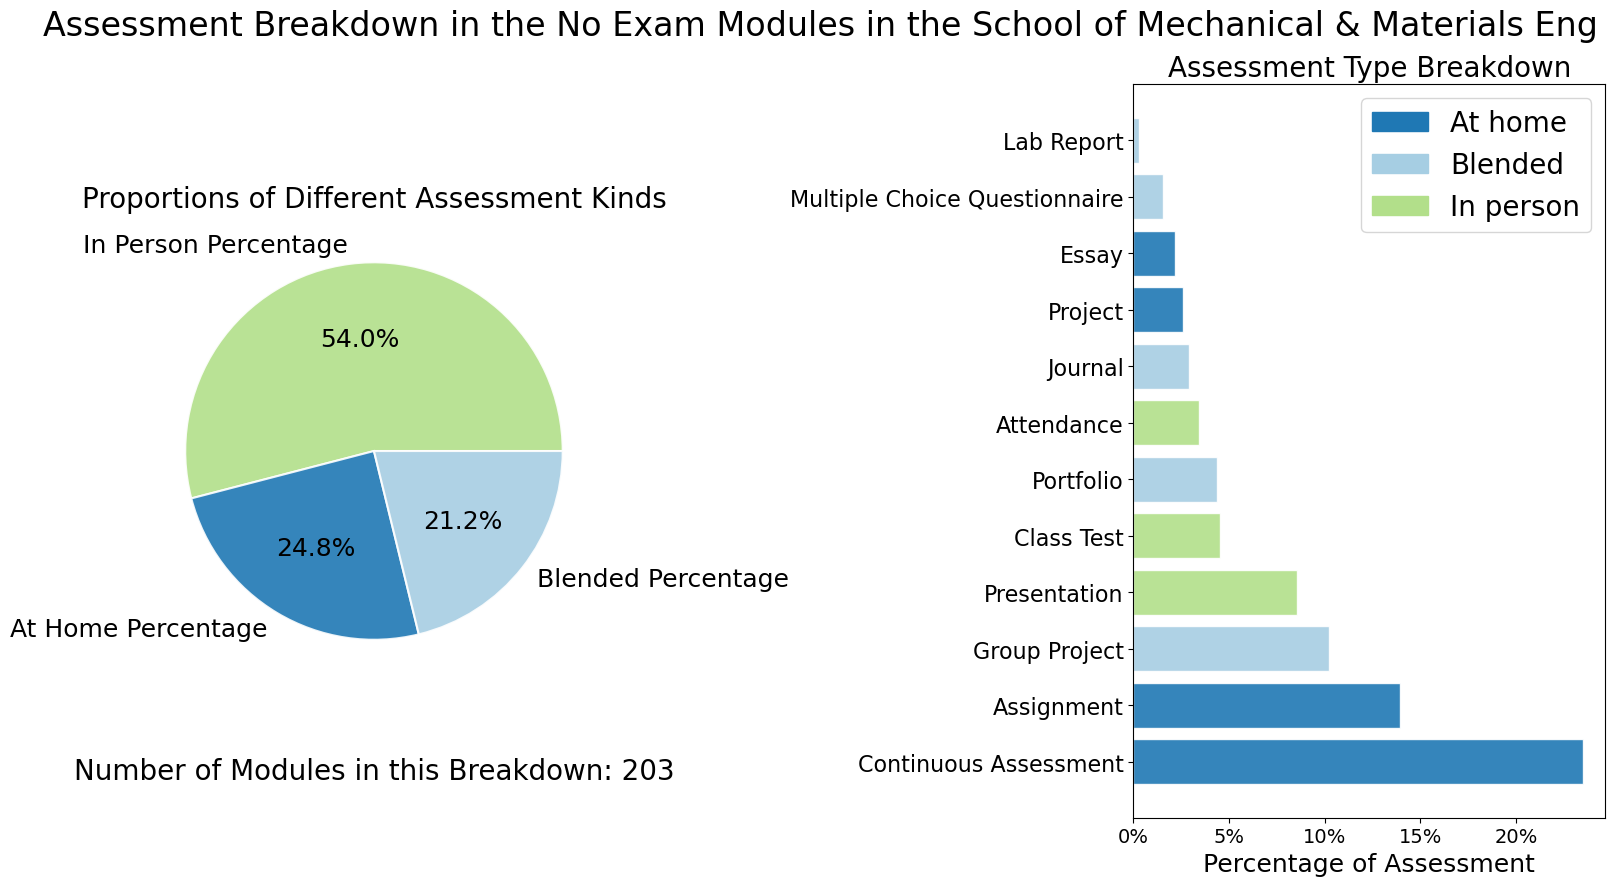

In [61]:
workType_builder(no_exam, school="Mechanical & Materials Eng")

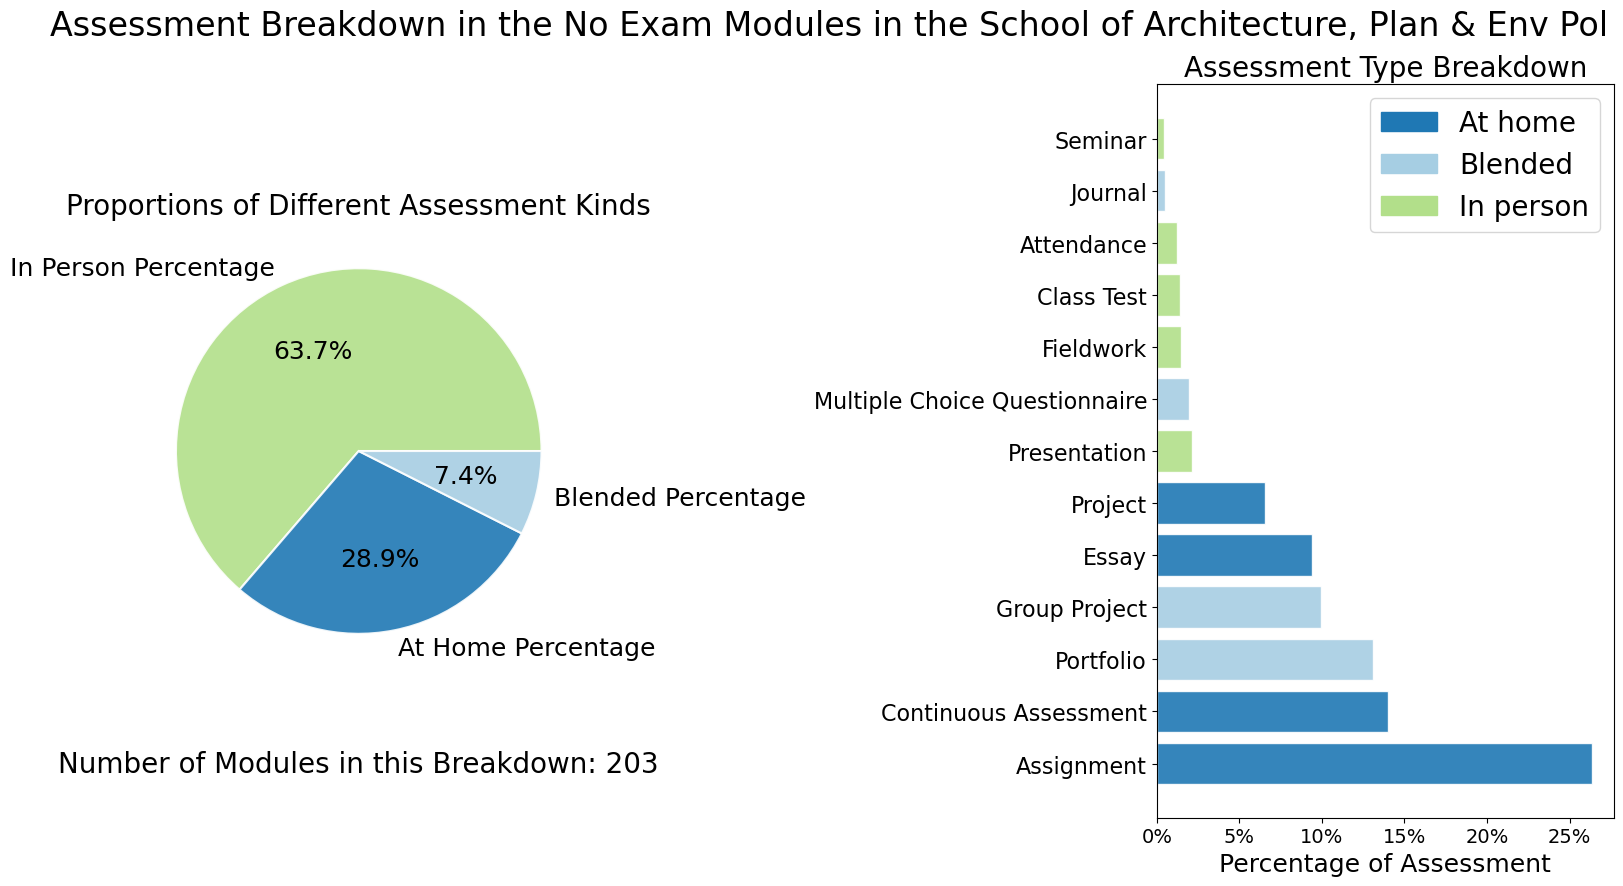

In [62]:
workType_builder(no_exam, school="Architecture, Plan & Env Pol")

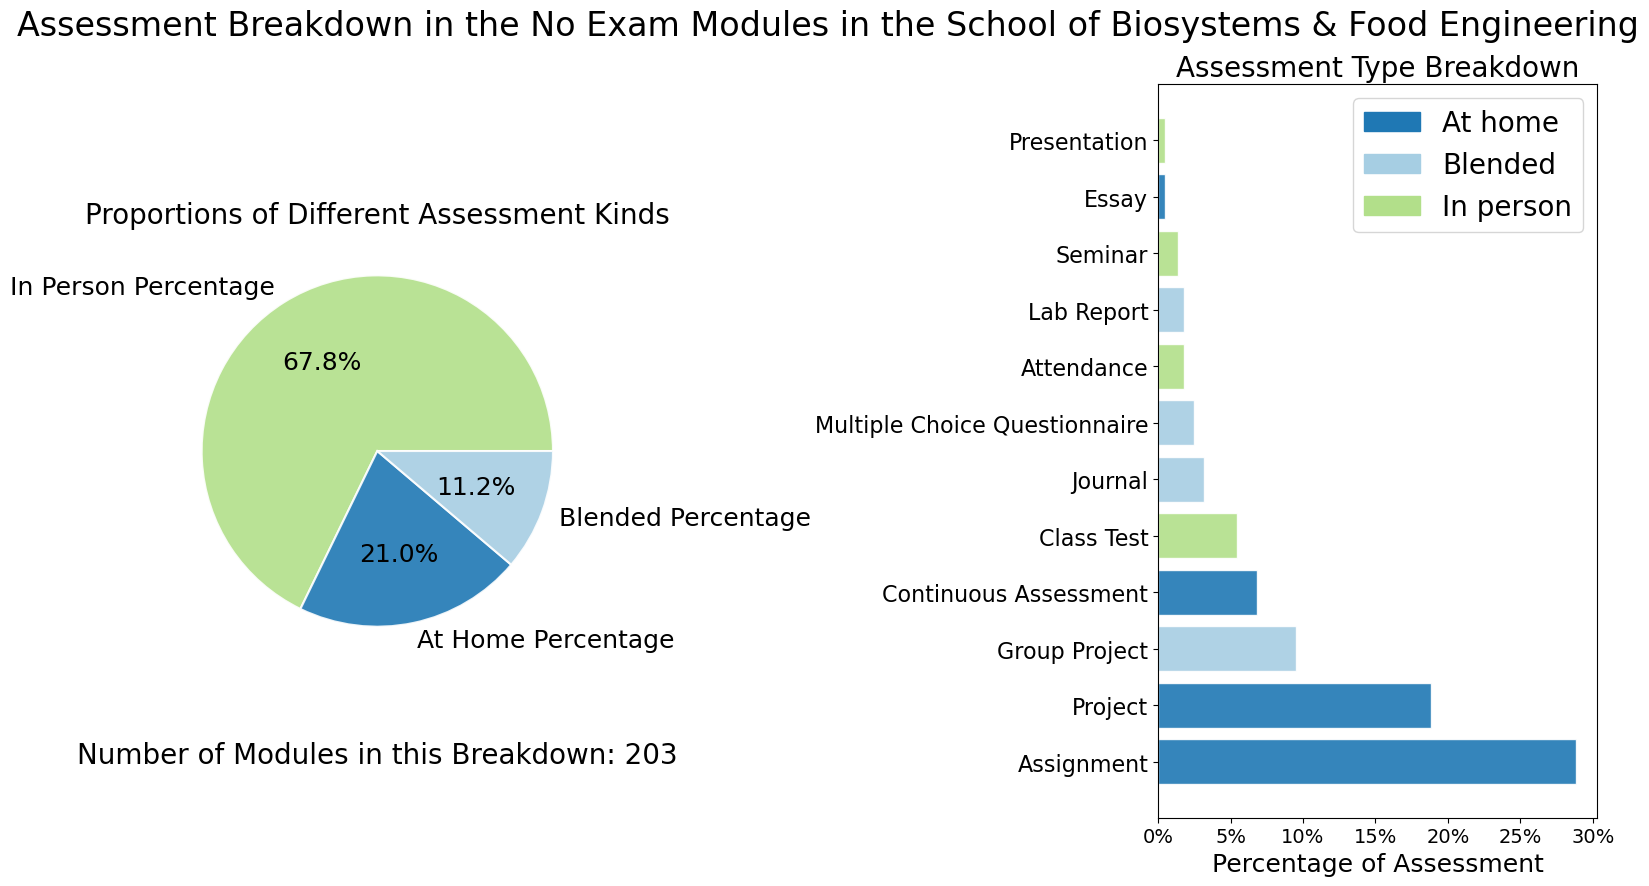

In [63]:
workType_builder(no_exam, school="Biosystems & Food Engineering")

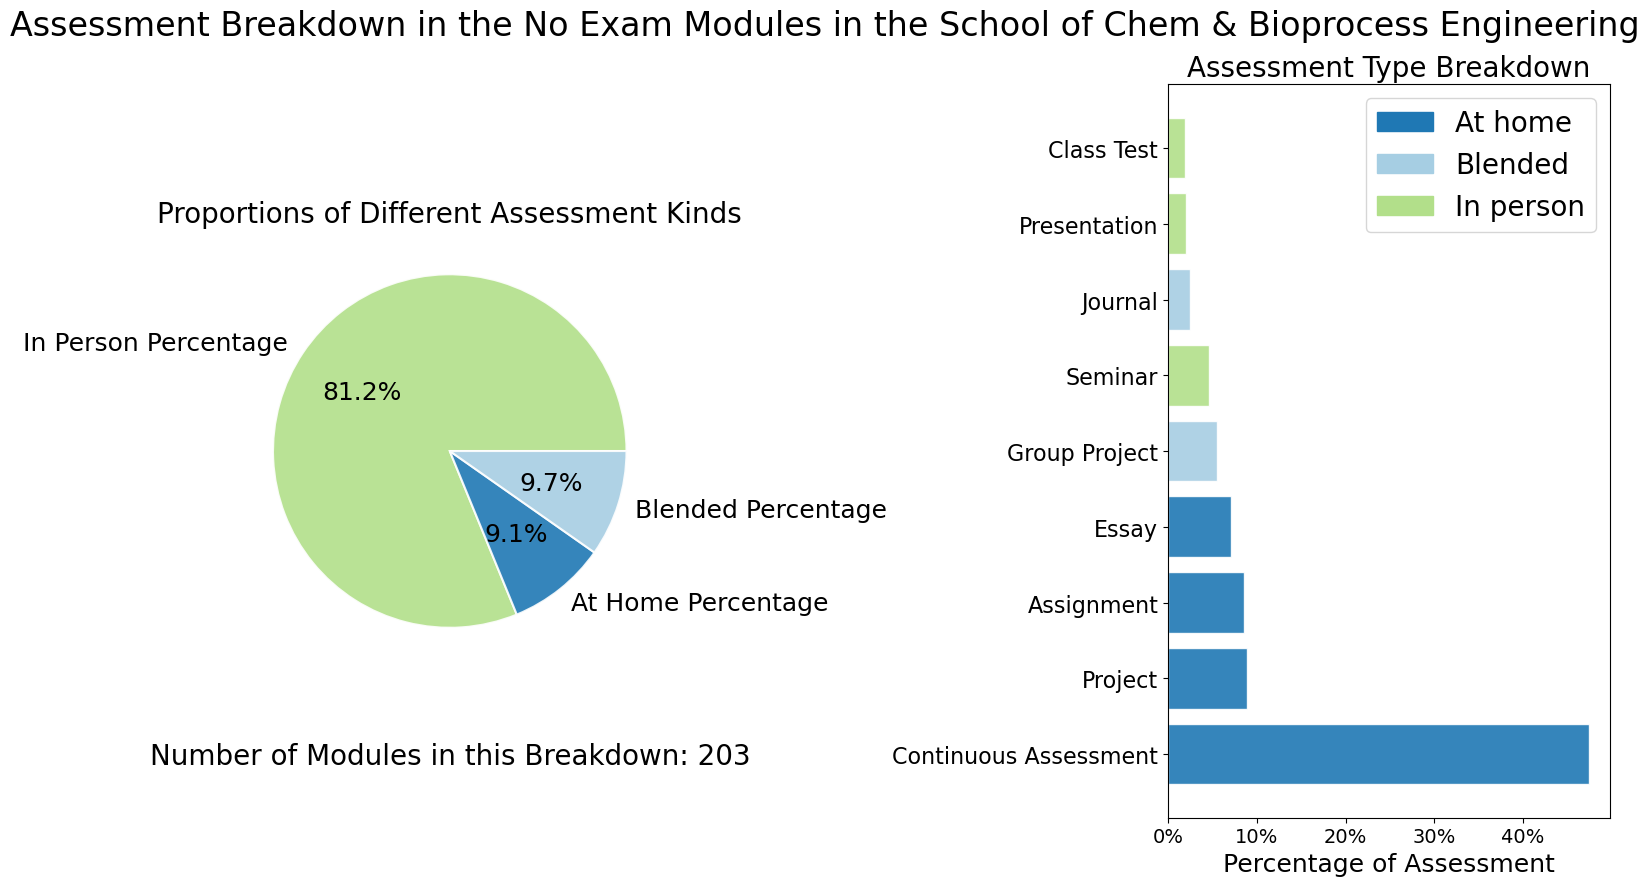

In [64]:
workType_builder(no_exam, school="Chem & Bioprocess Engineering")